In [1]:
import seaborn as sns
import numpy as np
import imageio
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import math
import torch
import nopdb
from tqdm.auto import tqdm
from scipy import ndimage
from scipy.special import softmax
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud
from point_e.util.plotting import plot_attention_cloud

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [3]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [4]:
# Load an image to condition on.
img = Image.open('example_data/no_background_chair.jpeg')

def est_attention(attn_call):
    attention_scores = attn_call.locals['weight'][0]
    attention_probs = attention_scores.softmax(dim=-1)
        # Average across all heads
    avg_attn = torch.mean(attention_probs, dim = 0)
    
    # Est. self attention
    pc_self_attn = avg_attn[257:, 257:]
    
    # Est. cross attention
    pc_cross_attn = avg_attn[:257, 257:] 

    pc_self_attn = pc_self_attn.cpu()
    pc_cross_attn = pc_cross_attn.cpu()
    avg_attn = avg_attn.cpu()
    return pc_self_attn, pc_cross_attn, avg_attn

    

def sample_from_model(breakpoint):
    # samples = None
    k = 0
    x_set = []
    pc_self_attns, pc_cross_attns, avg_attns = [], [], []
    with nopdb.capture_call(base_model.backbone.resblocks[-1].attn.attention.forward) as attn_call:
        for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
            # samples = x
            if k in breakpoint:
                x_set.append(x)
                pc_self_attn, pc_cross_attn, avg_attn = est_attention(attn_call)
                if x.shape[2] == 1024:
                    pc_self_attns.append(pc_self_attn)
                    pc_cross_attns.append(pc_cross_attn)
                    avg_attns.append(avg_attn)
            k += 1  
            
            if k == 66:
                break
                  
    # for sample in x_set:
    #     pc = sampler.output_to_point_clouds(samples)[0]
    #     c = np.diagonal(pc_self_attn)
    #     print(type(c))
    #     fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))
    #     fig.suptitle('iterations = ' + str(k))
    #     plt.savefig('Figures/Diffusion_gif_2/fig' + str(k) + '.png', bbox_inches='tight')
    #     image = imageio.v2.imread('Figures/Diffusion_gif_2/fig' + str(k) + '.png')
    #     frames.append(image)
        
    # imageio.mimsave('Figures/Diffusion_gif_2/Diffusion_at_scale.gif', # output gif
    #         frames,          # array of input frames
    #         fps = 0.5)         # optional: frames per second
    
    return pc_self_attns, pc_cross_attns, avg_attns, x_set

In [10]:
breakpoints = [0,30,40,41,42,43,44,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,-1]
# breakpoints =[0]
# time = [0, 1, 2, 3, 4, 5, 6, 7]

# Cross attention to conditioning image

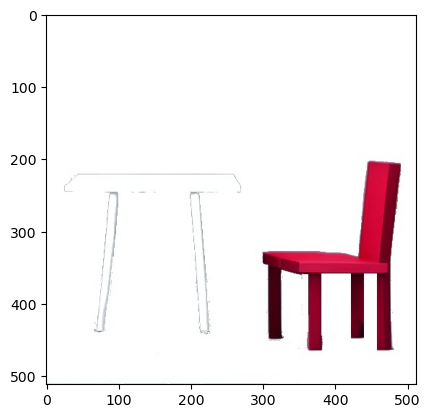

In [6]:
plt.imshow(img)

plt.show()

# Cross attention chair code

0it [00:00, ?it/s]

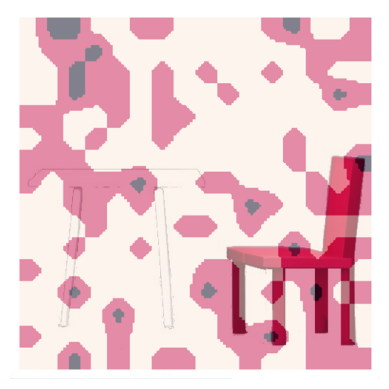

In [11]:
frames = []
# raw_frames = []
import torch.nn.functional as F

_, cross_attn, _, samples = sample_from_model(breakpoints)
for i,cross in enumerate(cross_attn):
    c = torch.mean(cross, dim= 1)
    sftm = torch.nn.Softmax(dim=0)
    c  = sftm(c)

    c = c[1:257]

    c = c.reshape(1,1,16,16)
# print(c.shape)
    c = F.interpolate(c,  size=(128,128), mode= 'bilinear')
    plt.axis('off')
    fig = plt.imshow(c.squeeze(),cmap = 'rocket_r')
    plt.savefig('Figures/cross_Attn_gif/fig' + str(i) + '.png', bbox_inches='tight')
    attention_img = Image.open('Figures/cross_Attn_gif/fig' + str(i) + '.png').convert('RGB')
    img = img.resize((500,500))
    attention_img = attention_img.resize((500,500))
    outpict = Image.blend(img,attention_img, 0.5)
    fig = plt.imshow(outpict)
    plt.savefig('Figures/cross_Attn_gif/blended_fig'+ str(i) + '.png', bbox_inches='tight', dpi = 300)
# fig = plot_attention_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)), col = c)
# plt.savefig('Figures/cross_Attn_gif/fig' + str(k) + '.png', bbox_inches='tight')

# image = imageio.v2.imread('Figures/cross_Attn_gif/fig' + str(k) + '.png')
# raw_frames.append(c)
    frames.append(outpict) 

In [9]:
imageio.mimsave('Figures/cross_Attn_gif/cross_attn_Diffusion_chair.gif', # output gif
                frames,          # array of input frames
                duration = 250)   

# Average attention all points.

In [ ]:
frames = []

self_attn, _, _, samples = sample_from_model(breakpoints)
for i, (attn,sample) in enumerate(zip(self_attn, samples)):
    # print(attn.shape)
    pc = sampler.output_to_point_clouds(sample)[0]
    c = softmax(np.mean(attn.numpy(), axis= 0))
    fig = plot_attention_cloud(pc, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)), col = c)
    plt.savefig('Figures/avg_Attn_gif/clean_fig' + str(i) + '.png', bbox_inches='tight')

    image = imageio.v2.imread('Figures/avg_Attn_gif/clean_fig' + str(i) + '.png')
    frames.append(image) 

: 

In [ ]:

imageio.mimsave('Figures/avg_Attn_gif/clean_avg_attn_Diffusion_chair.gif', # output gif
                frames,          # array of input frames
                duration = 250)   

# Code to plot colored attention clouds 

In [6]:
frames = []
import numpy as np
for k in breakpoints:
    pc_self_attn, pc_cross_attn, avg_attn, samples = sample_from_model(k)
    pc = sampler.output_to_point_clouds(samples)[0]
    c = np.diagonal(pc_self_attn)
    print(type(c))
    fig = plot_attention_cloud(pc, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)), col = c)
    plt.savefig('Figures/Diffusion_gif/fig' + str(k) + '.png', bbox_inches='tight')
    image = imageio.v2.imread('Figures/Diffusion_gif/fig' + str(k) + '.png')
    frames.append(image)
    
    
    
imageio.mimsave('Figures/Diffusion_gif/Diffusion.gif', # output gif
                frames,          # array of input frames
                fps = 0.5)         # optional: frames per second

NameError: name 'breakpoints' is not defined

In [ ]:
    
imageio.mimsave('Figures/Diffusion_gif/Diffusion.gif', # output gif
                frames,          # array of input frames
                fps = 0.5)         # optional: frames per second

# OG plot

In [5]:
# Load an image to condition on.
img = Image.open('example_data/chair.jpeg')

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x

0it [00:00, ?it/s]

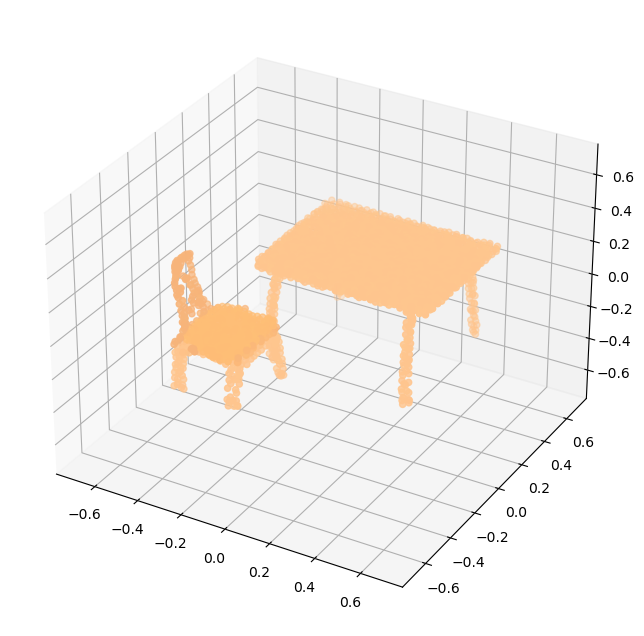

: 

In [6]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [ ]:
plt.imshow(img)